#  **Clone Repo and install dependencies** 

In [3]:
!git clone https://github.com/ultralytics/yolov5
!pip install -qr yolov5/requirements.txt
%cd yolov5

import torch
from IPython.display import Image, clear_output
#from utils.google_utils import gdrive_download
from utils import *
clear_output()

# **Download the dataset from Roboflow 
Generate your key for the dataset from here..
: [Link](https://public.roboflow.com/object-detection/wildfire-smoke/)**

In [4]:
%cd /content
!curl -L "https://public.roboflow.com/ds/ ADD YOUR KEY " > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0    576      0  0:00:01  0:00:01 --:--:--   575
100 27.6M  100 27.6M    0     0  15.0M      0  0:00:01  0:00:01 --:--:-- 15.0M
Archive:  roboflow.zip
 extracting: test/images/ck0rqdyeq4kxa08633xv2wqe1_jpeg.rf.30df6babe258cdc1d5a4e042262665e4.jpg  
 extracting: test/images/ck0qd918zic840701hnezgpgy_jpeg.rf.30de65aa3639b8a113db71a11bc2726c.jpg  
 extracting: test/images/ck0kfjen48qhj0701wjkosmel_jpeg.rf.49b365cc7135deee1332e6657401abc5.jpg  
 extracting: test/images/ck0t7cczuqxtt07212nj5eznh_jpeg.rf.1a9299c8658d89f6271dba2aeefe074d.jpg  
 extracting: test/images/ck0kn8y5y9y3507018k5p06ma_jpeg.rf.466b2fb63a73c0138cf75b3ddc71d490.jpg  
 extracting: test/images/ck0tzjni6sjt50863e6a6a8fl_jpeg.rf.46d343d22cd08c90668cc0d50bc52a2d.jpg  
 extracting: test/images/ck0tszlepw02k0721zr71djfj_jpeg.rf.2c8ed

In [5]:
#extracting information from the roboflow file
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 1
names: ['smoke']

In [6]:
# define number of classes based on data.yaml
import yaml
with open("data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

# **Use a custom model configuration**

In [8]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [9]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

# **Train on new dataset**

In [10]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
100% 755k/755k [00:00<00:00, 19.0MB/s]
train: weights=, cfg=./models/custom_yolov5s.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=yolov5s_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0, patience=100
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-447-g4d1a2ac torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_

# **Test on Images and Videos**

In [15]:
!python detect.py --weights runs/train/yolov5s_results/weights/last.pt --img 416 --conf 0.4 --source ../test/images

detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../test/images, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False
YOLOv5 🚀 v5.0-447-g4d1a2ac torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
Model Summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/74 /content/test/images/ck0kcoc8ik6ni0848clxs0vif_jpeg.rf.8b4629777ffe1d349cc970ee8af59eac.jpg: 320x416 1 smoke, Done. (0.019s)
image 2/74 /content/test/images/ck0kd4afx8g470701watkwxut_jpeg.rf.bb5a1f2c2b04be20c948fd3c5cec33ff.jpg: 320x416 1 smoke, Done. (0.018s)
image 3/74 /content/test/images/ck0kdhymna0b10721v4wntit8_jpeg.rf.a08e34d04fb672ce6cf8e94e810ec81d.jpg: 320x416 1 smoke, Done. 

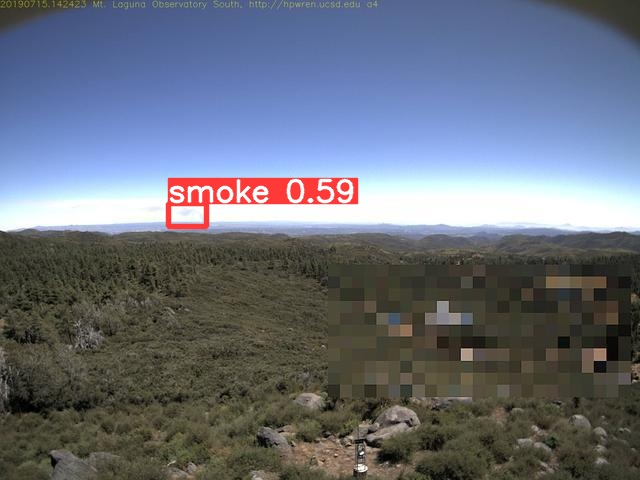

You see Predictive Probability in the BoX 



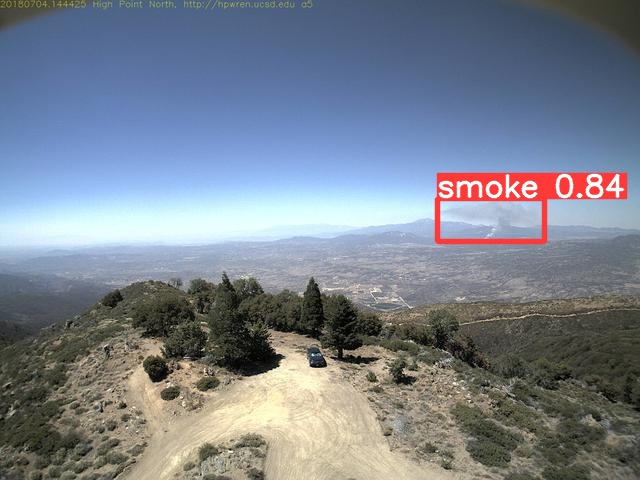

You see Predictive Probability in the BoX 



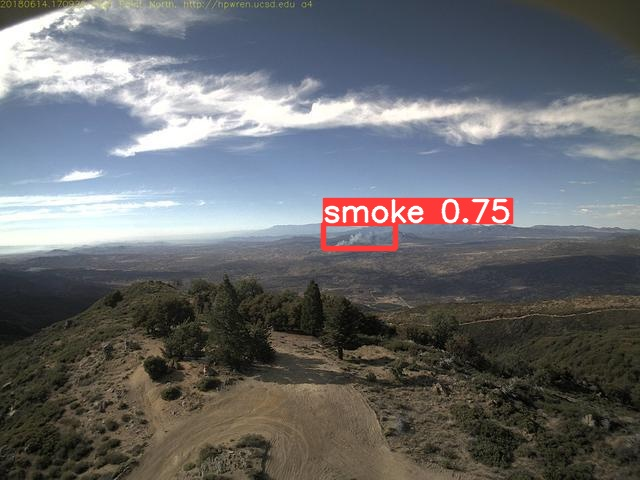

You see Predictive Probability in the BoX 



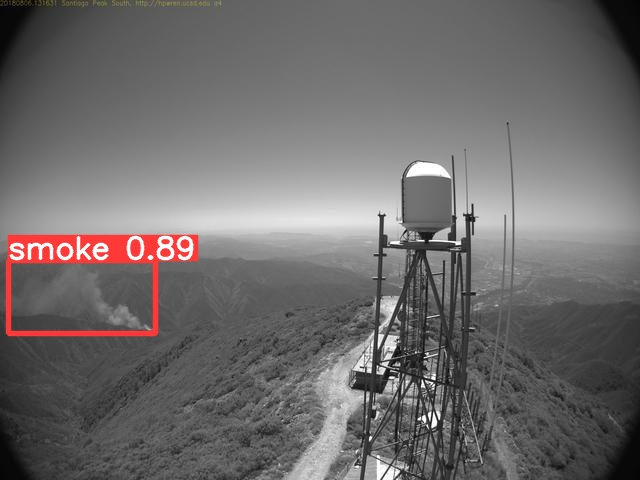

You see Predictive Probability in the BoX 



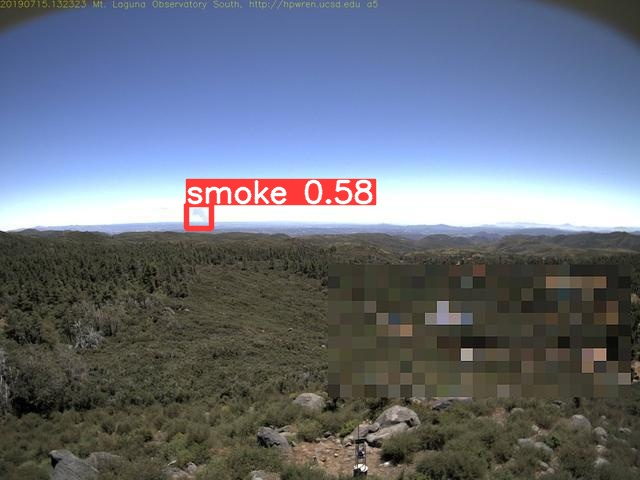

You see Predictive Probability in the BoX 



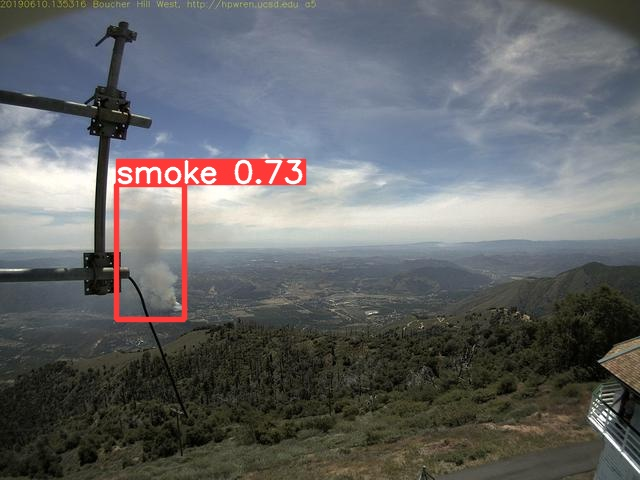

You see Predictive Probability in the BoX 



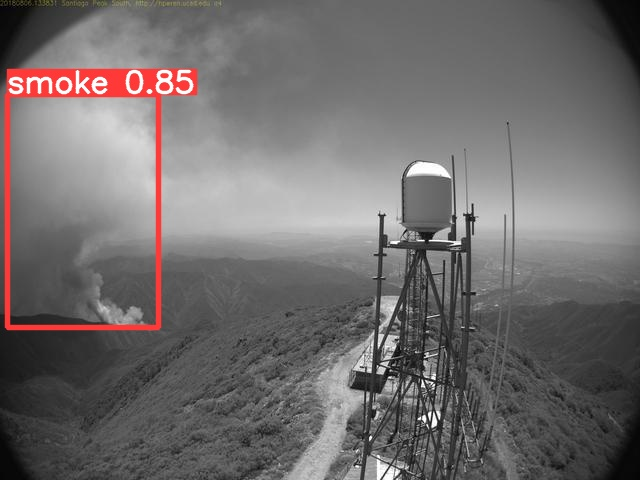

You see Predictive Probability in the BoX 



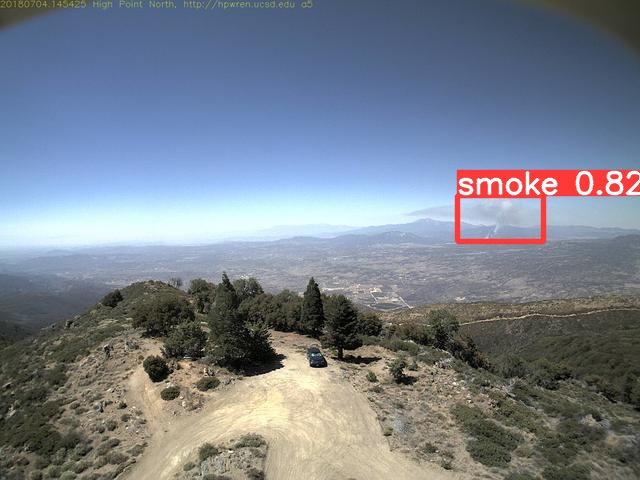

You see Predictive Probability in the BoX 



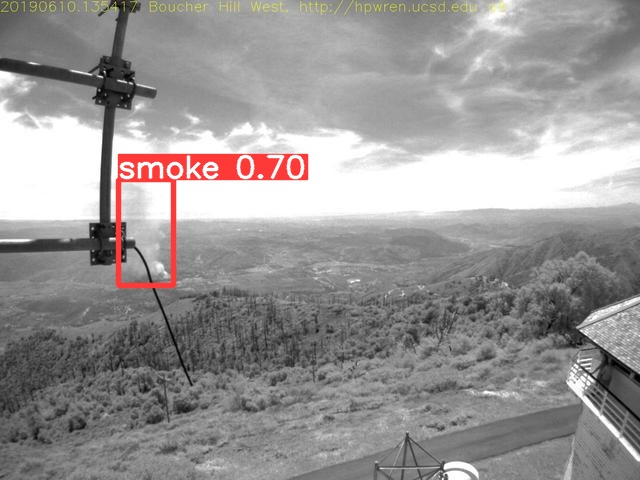

You see Predictive Probability in the BoX 



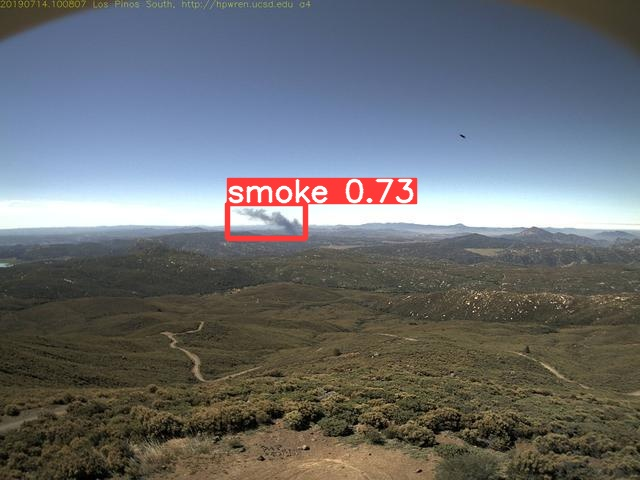

You see Predictive Probability in the BoX 



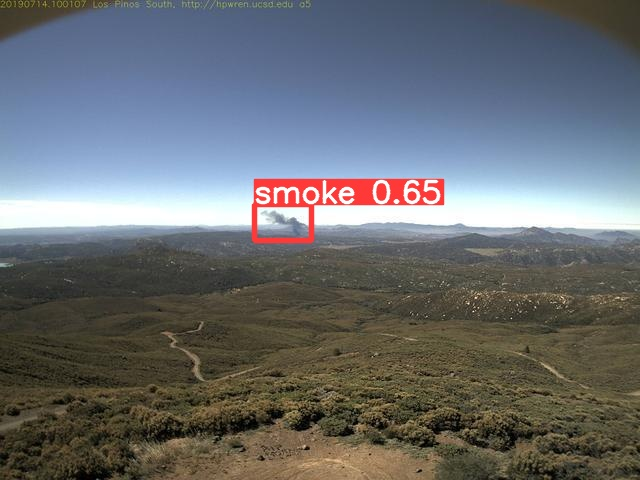

You see Predictive Probability in the BoX 



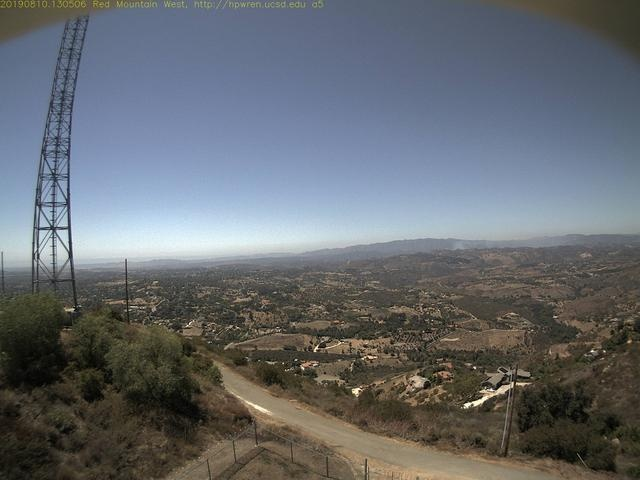

You see Predictive Probability in the BoX 



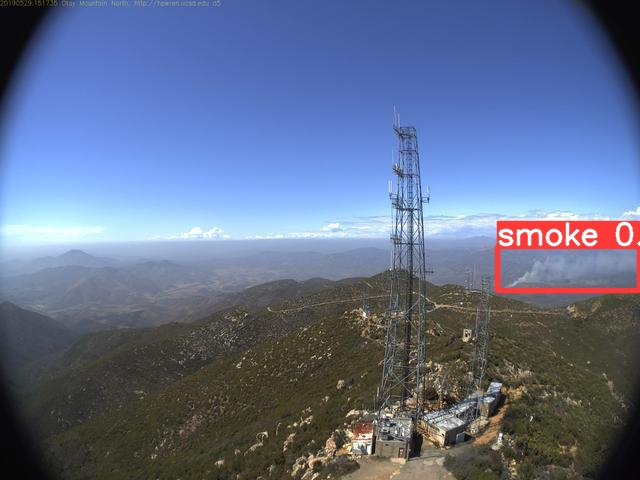

You see Predictive Probability in the BoX 



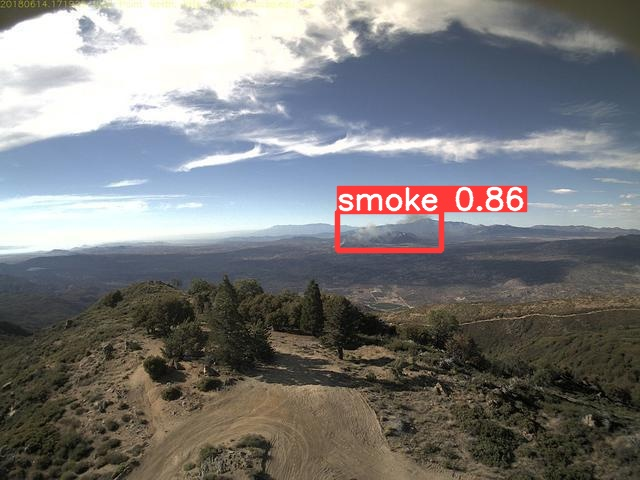

You see Predictive Probability in the BoX 



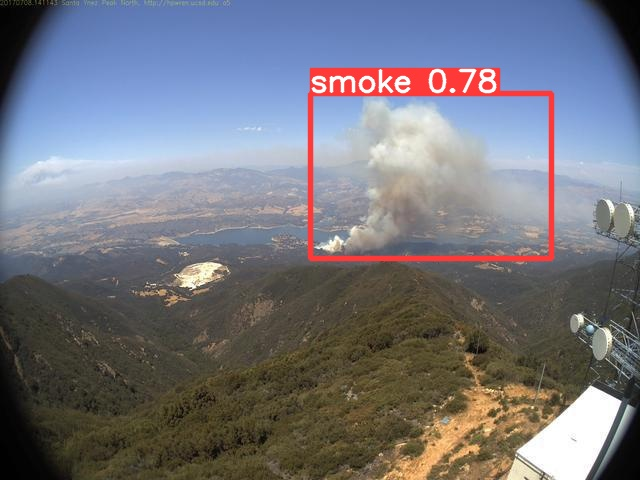

You see Predictive Probability in the BoX 



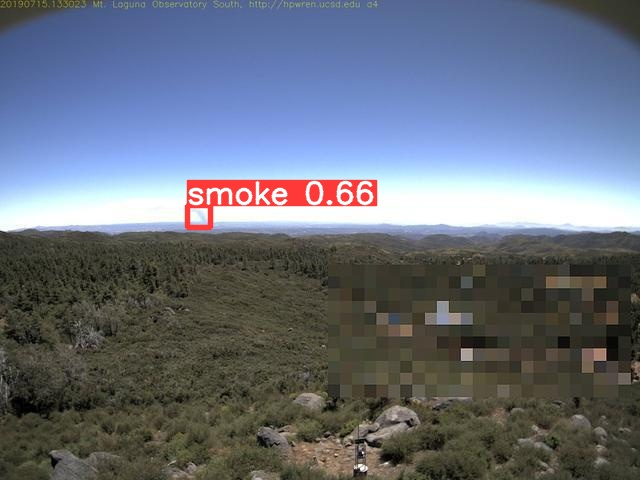

You see Predictive Probability in the BoX 



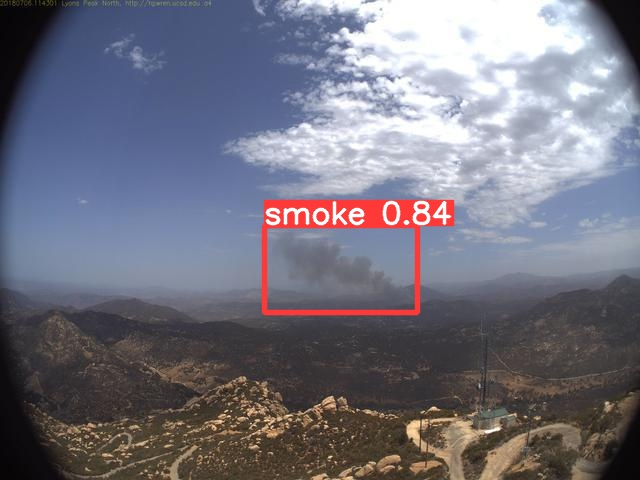

You see Predictive Probability in the BoX 



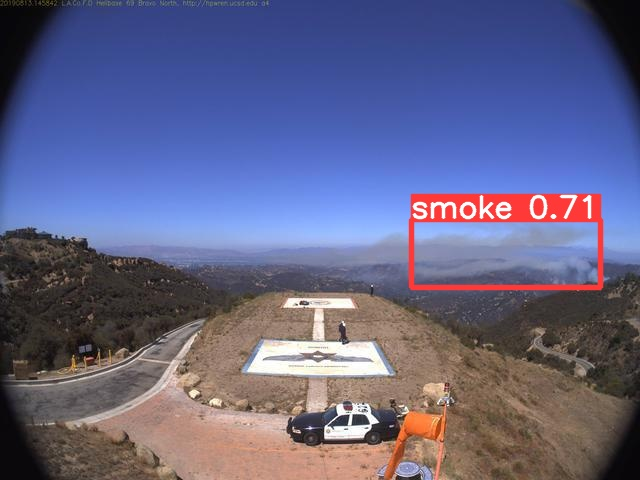

You see Predictive Probability in the BoX 



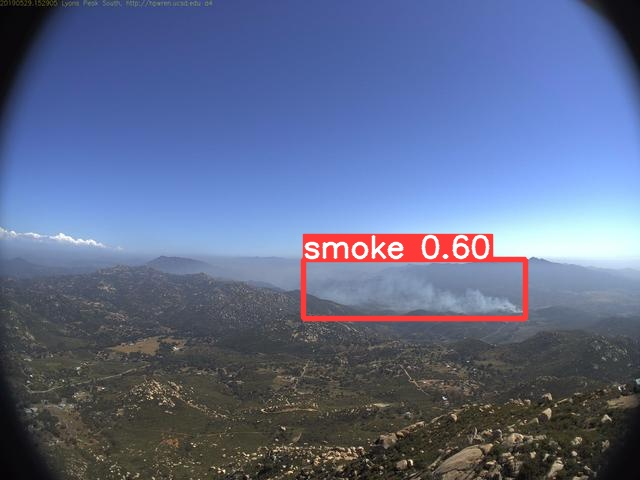

You see Predictive Probability in the BoX 



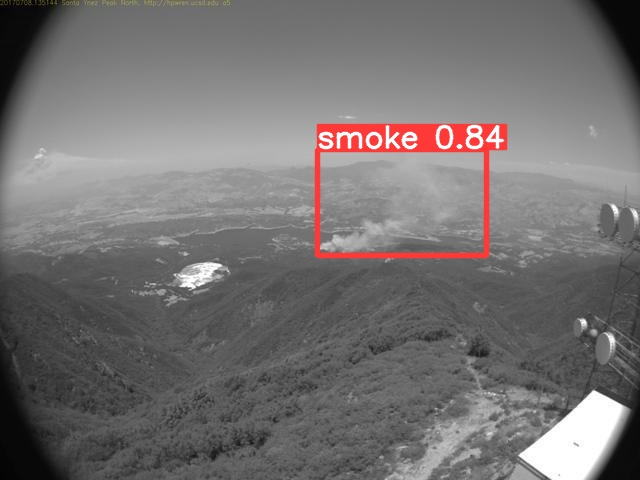

You see Predictive Probability in the BoX 



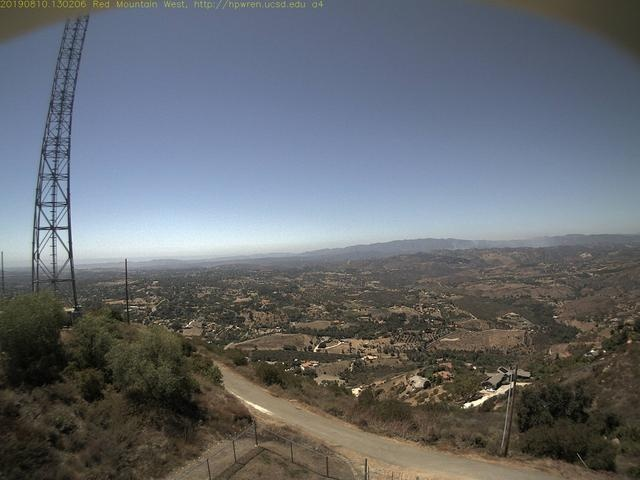

You see Predictive Probability in the BoX 



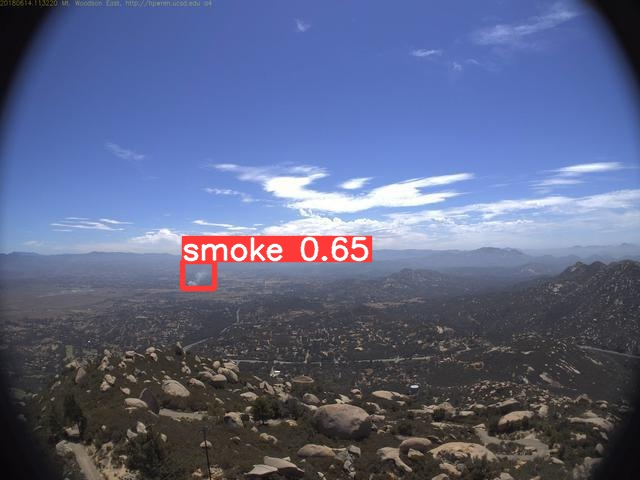

You see Predictive Probability in the BoX 



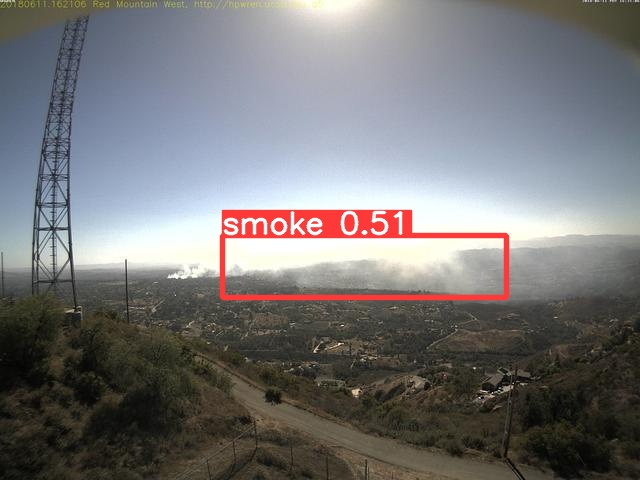

You see Predictive Probability in the BoX 



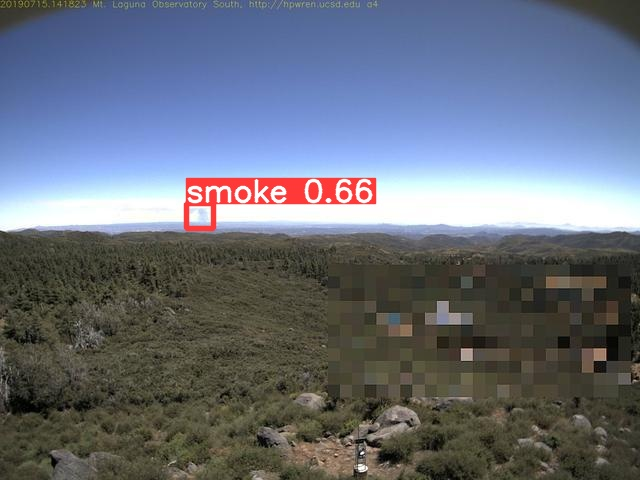

You see Predictive Probability in the BoX 



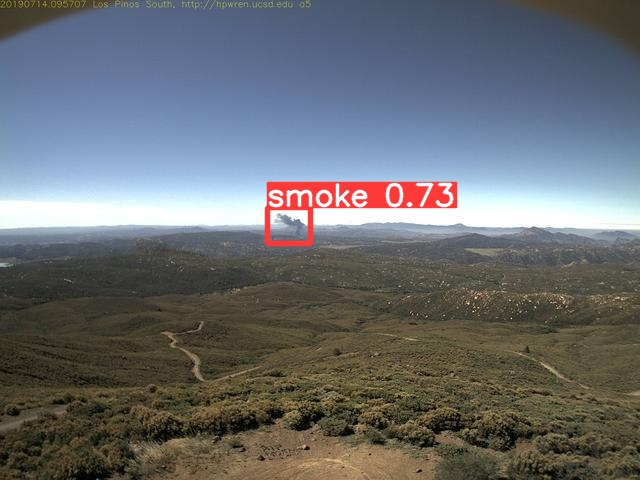

You see Predictive Probability in the BoX 



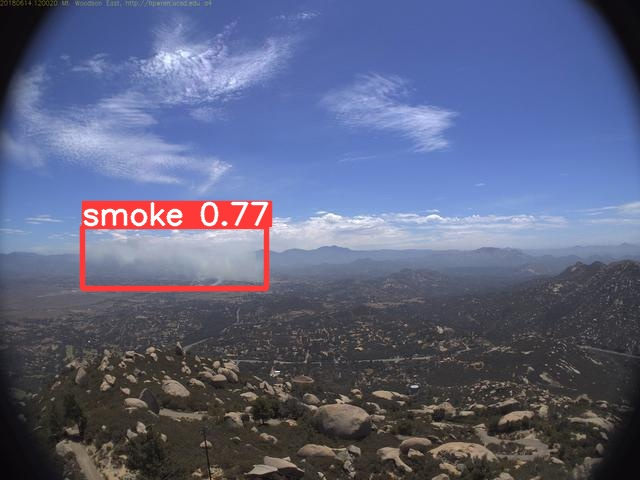

You see Predictive Probability in the BoX 



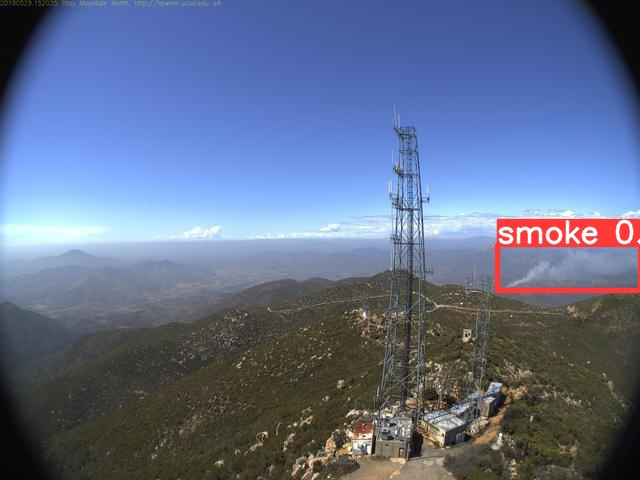

You see Predictive Probability in the BoX 



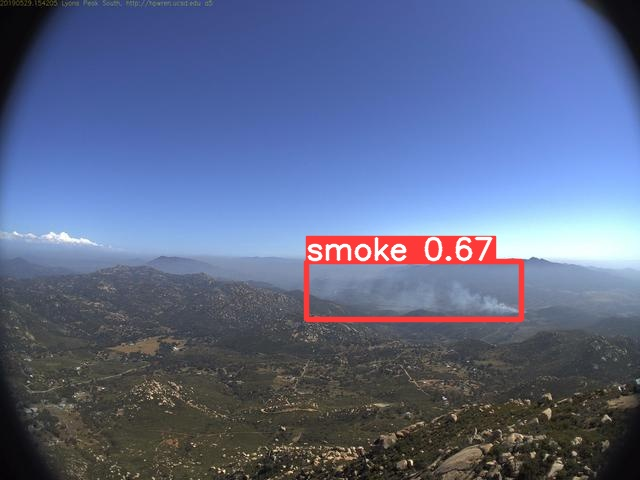

You see Predictive Probability in the BoX 



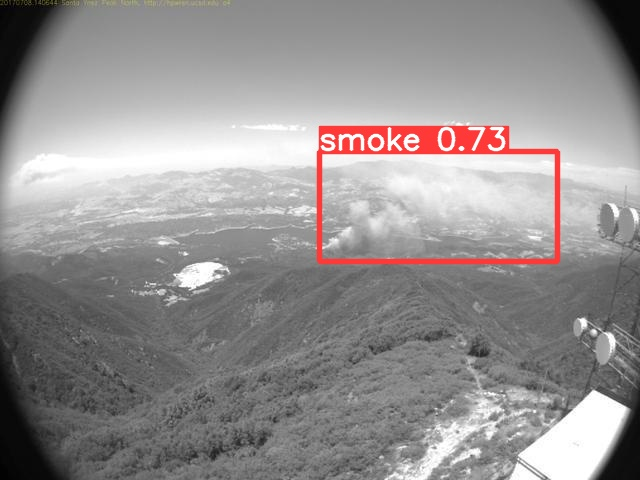

You see Predictive Probability in the BoX 



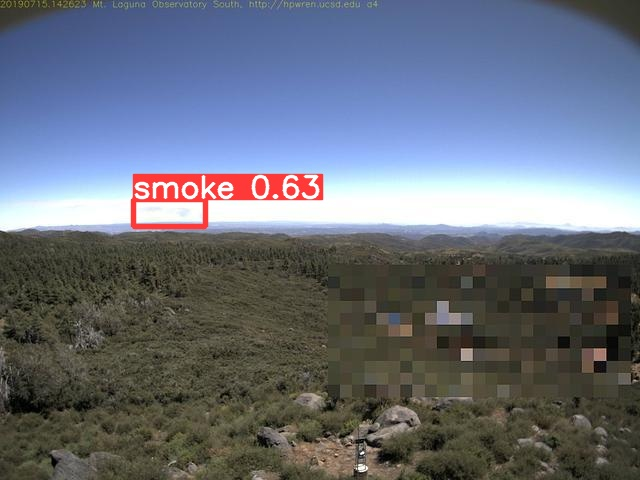

You see Predictive Probability in the BoX 



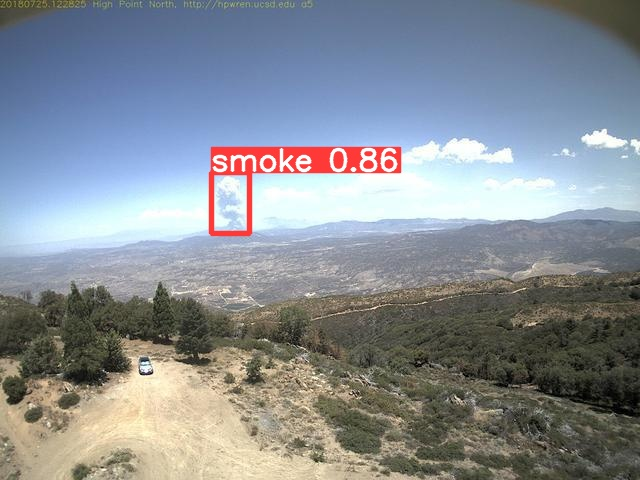

You see Predictive Probability in the BoX 



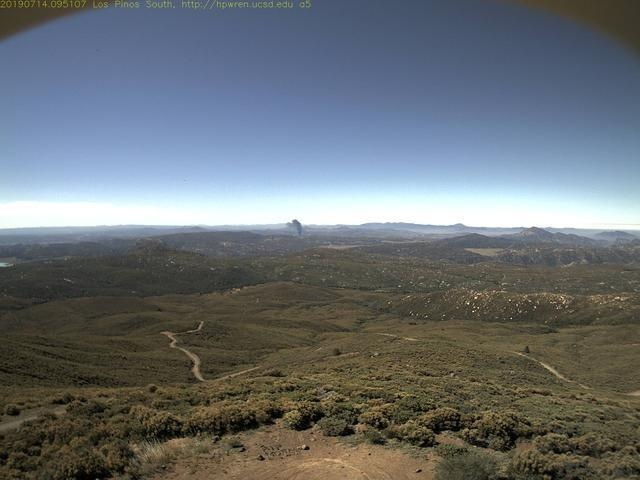

You see Predictive Probability in the BoX 



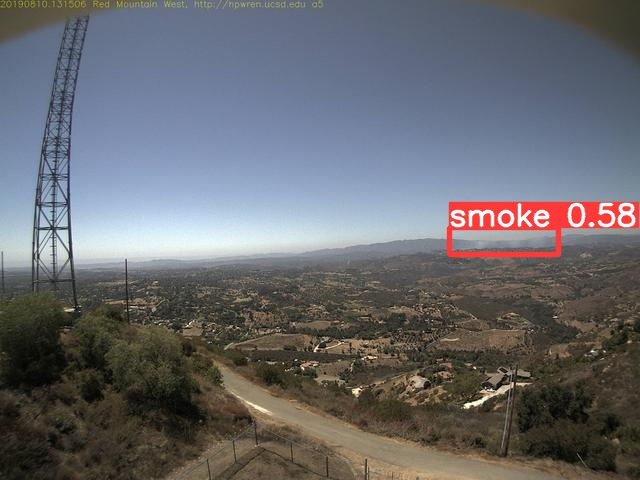

You see Predictive Probability in the BoX 



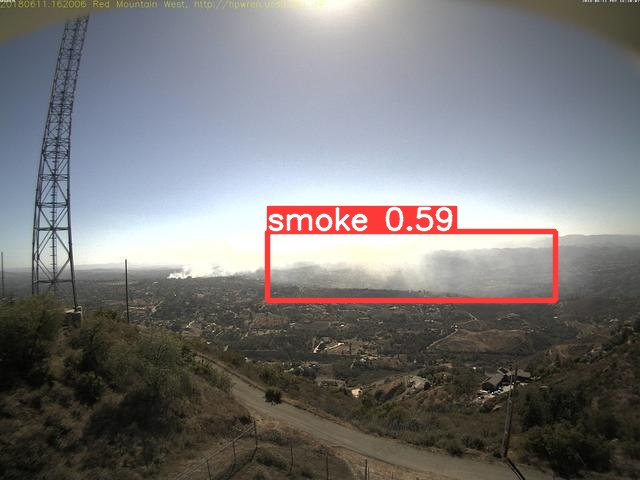

You see Predictive Probability in the BoX 



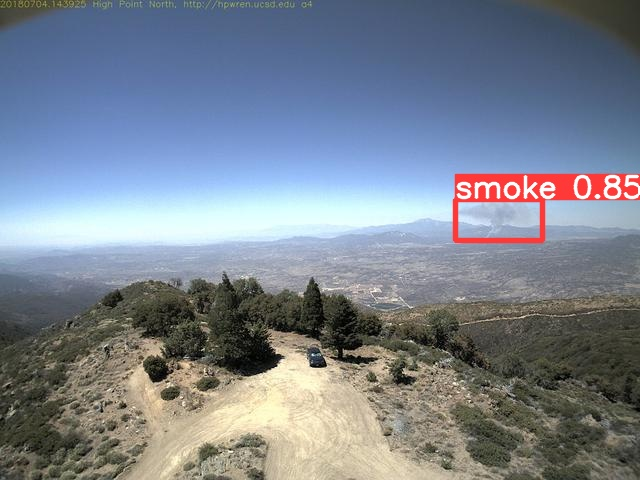

You see Predictive Probability in the BoX 



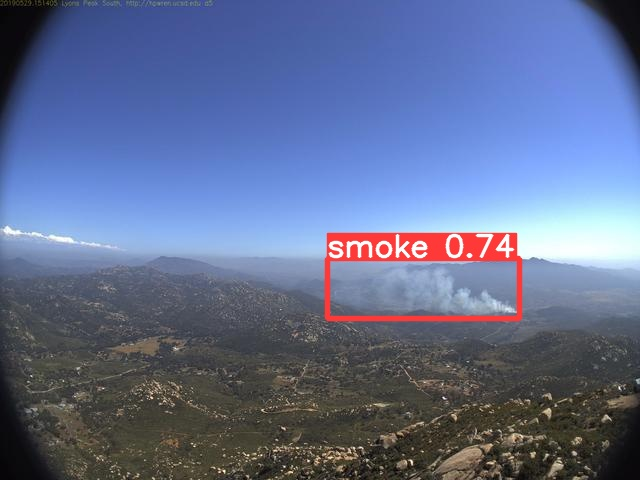

You see Predictive Probability in the BoX 



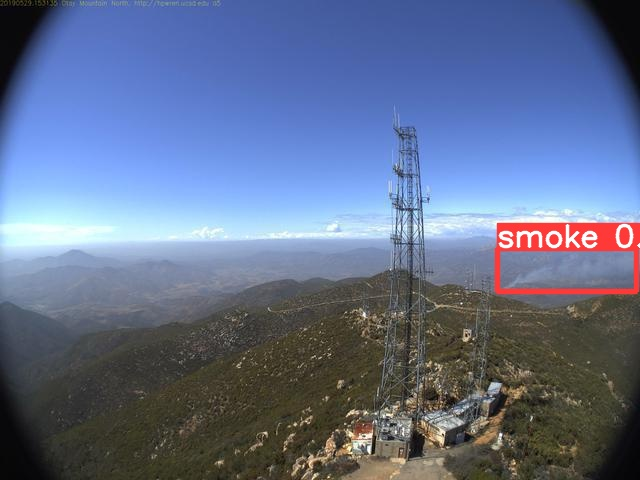

You see Predictive Probability in the BoX 



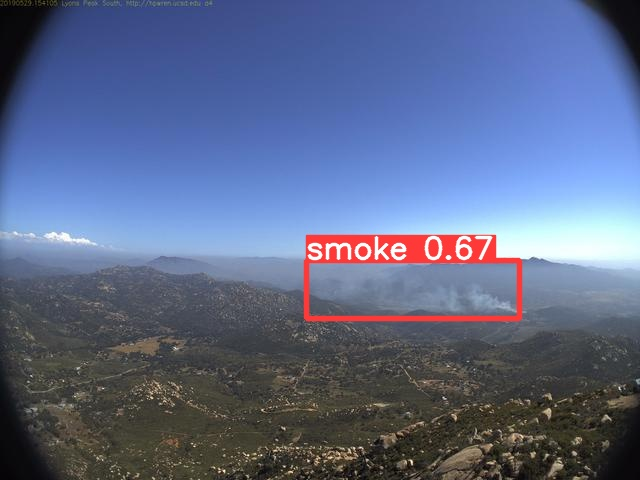

You see Predictive Probability in the BoX 



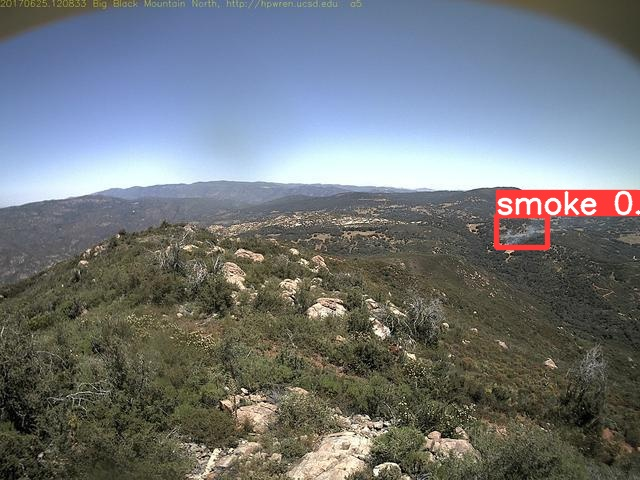

You see Predictive Probability in the BoX 



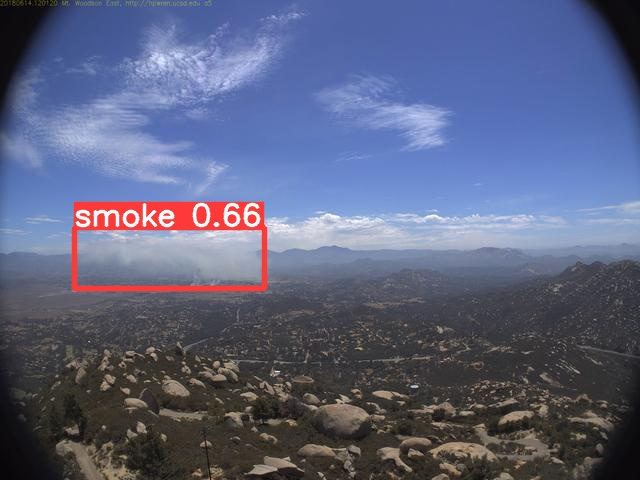

You see Predictive Probability in the BoX 



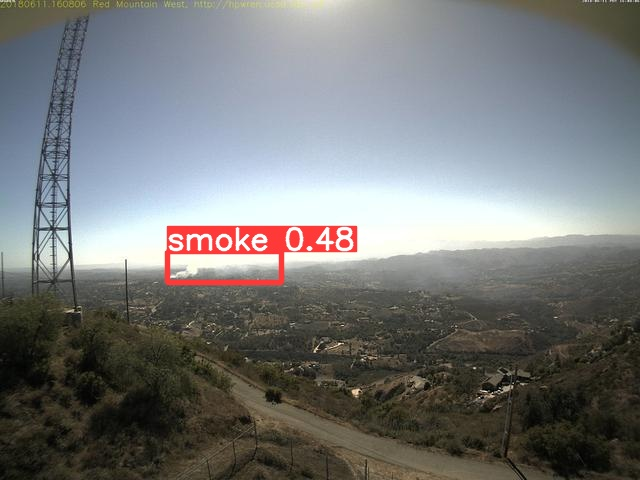

You see Predictive Probability in the BoX 



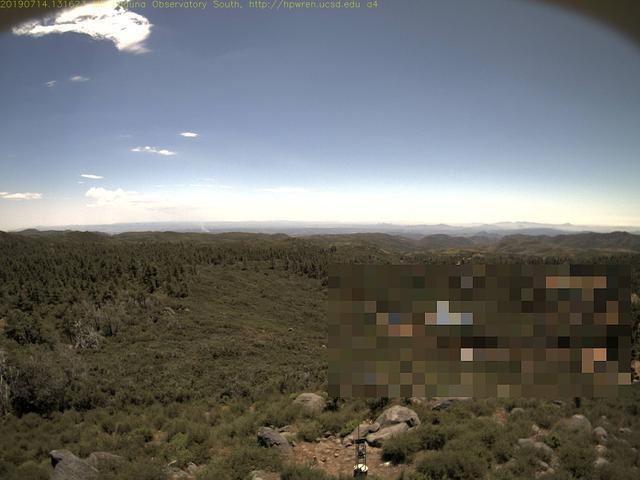

You see Predictive Probability in the BoX 



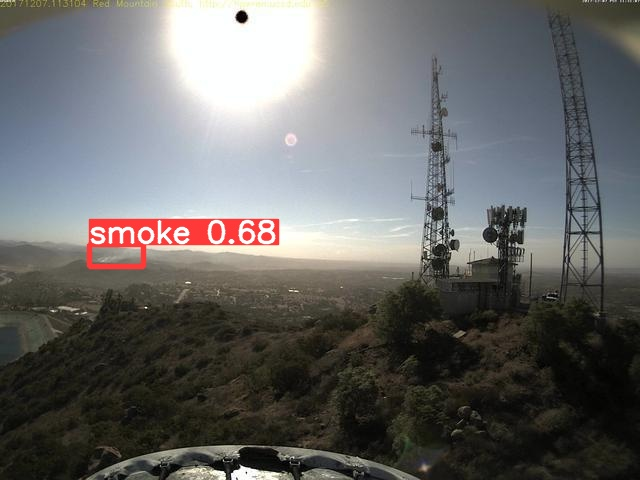

You see Predictive Probability in the BoX 



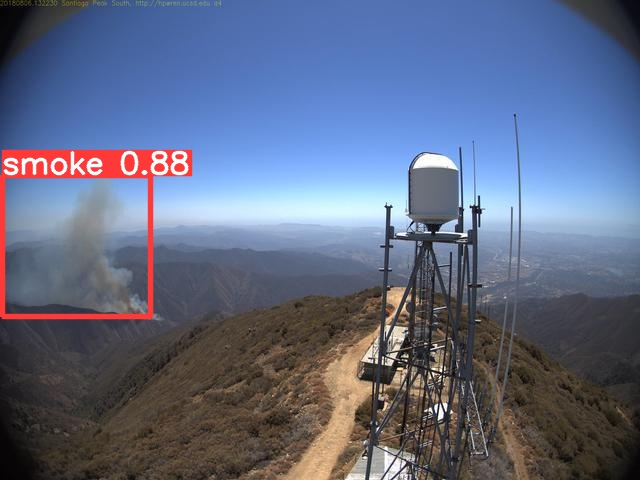

You see Predictive Probability in the BoX 



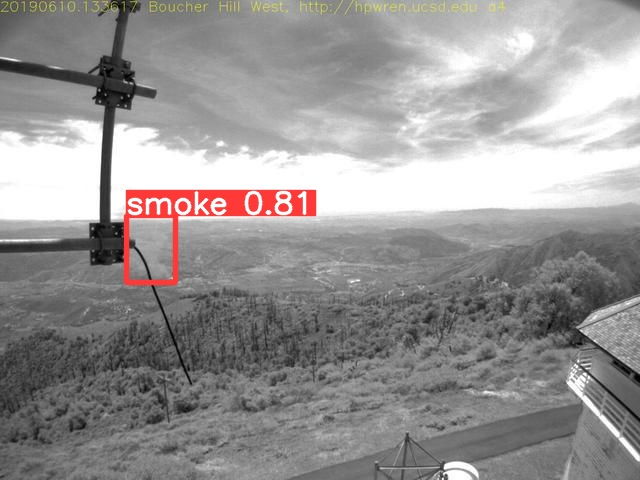

You see Predictive Probability in the BoX 



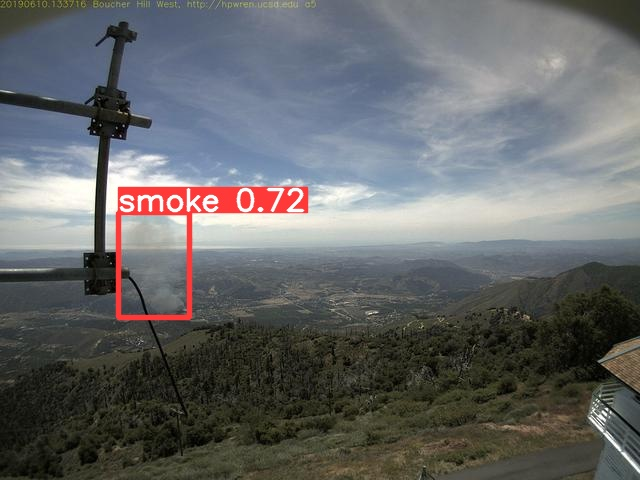

You see Predictive Probability in the BoX 



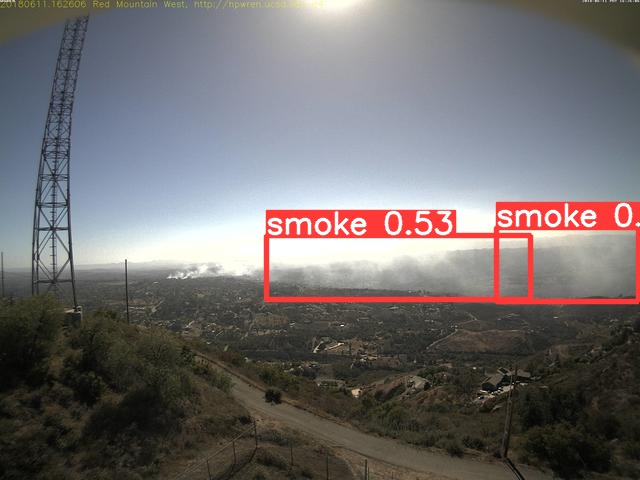

You see Predictive Probability in the BoX 



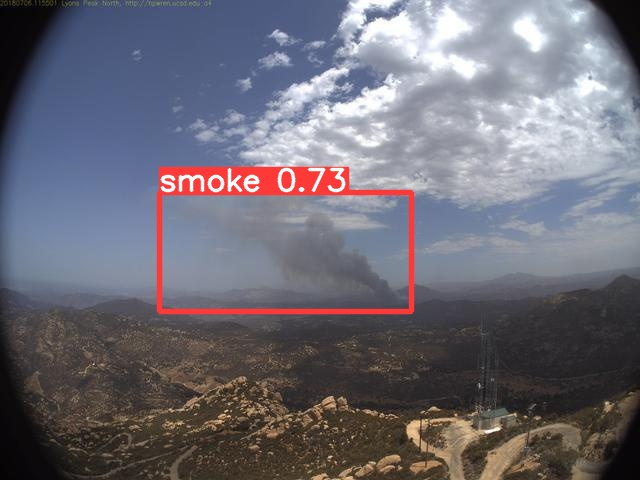

You see Predictive Probability in the BoX 



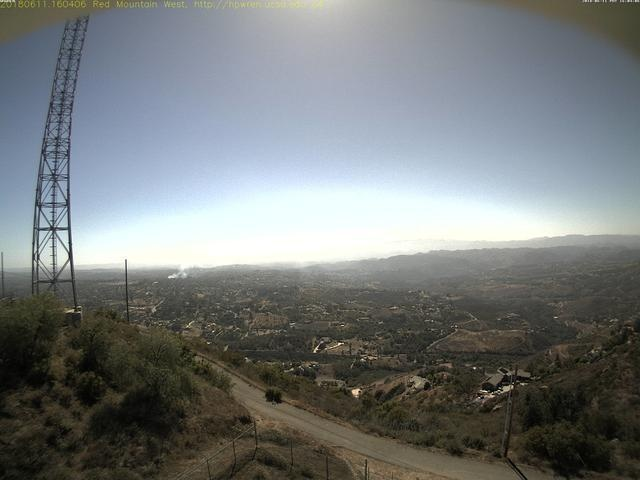

You see Predictive Probability in the BoX 



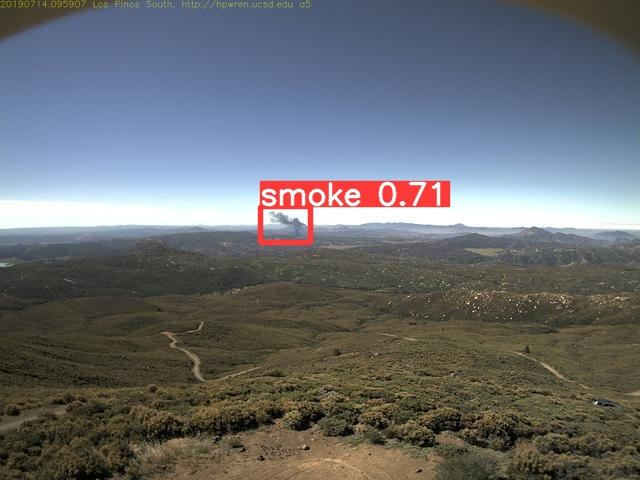

You see Predictive Probability in the BoX 



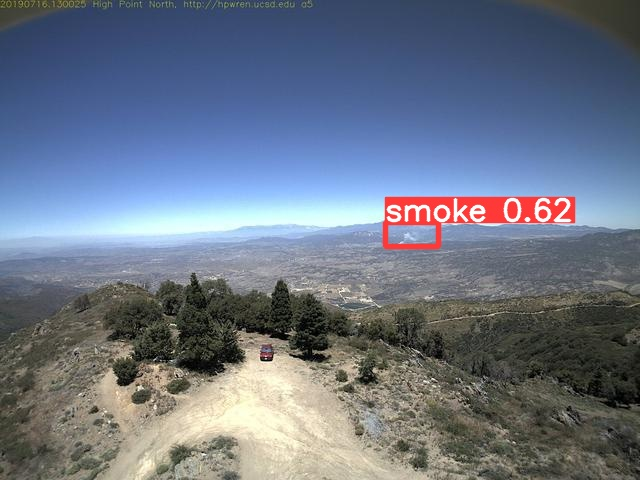

You see Predictive Probability in the BoX 



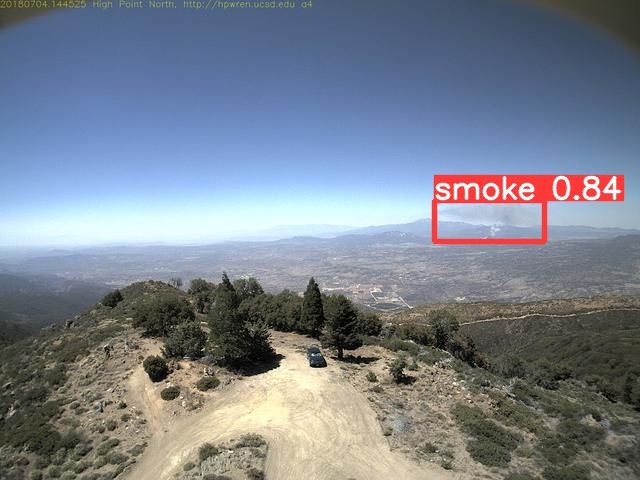

You see Predictive Probability in the BoX 



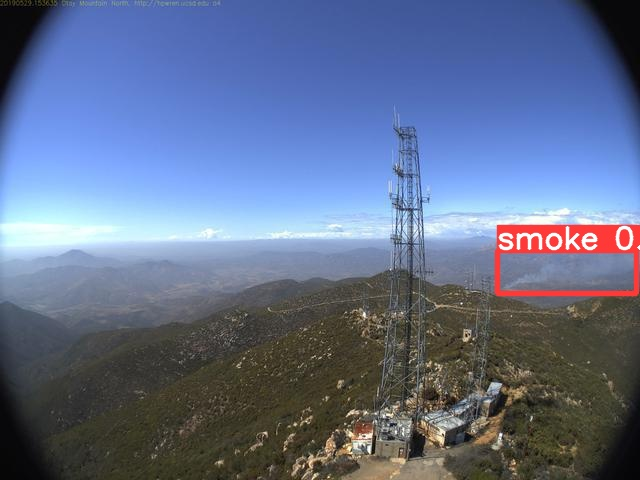

You see Predictive Probability in the BoX 



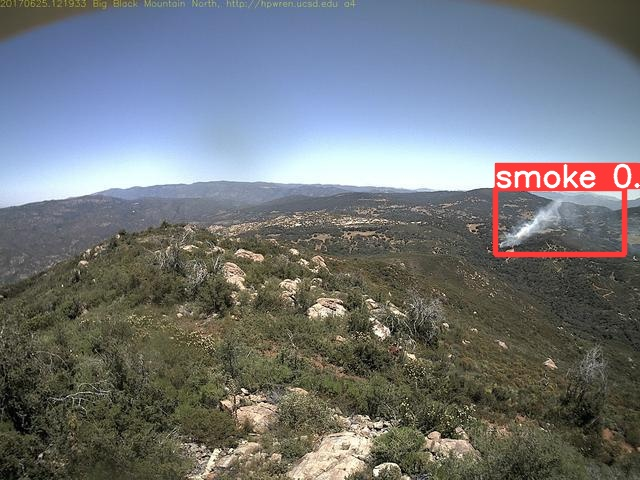

You see Predictive Probability in the BoX 



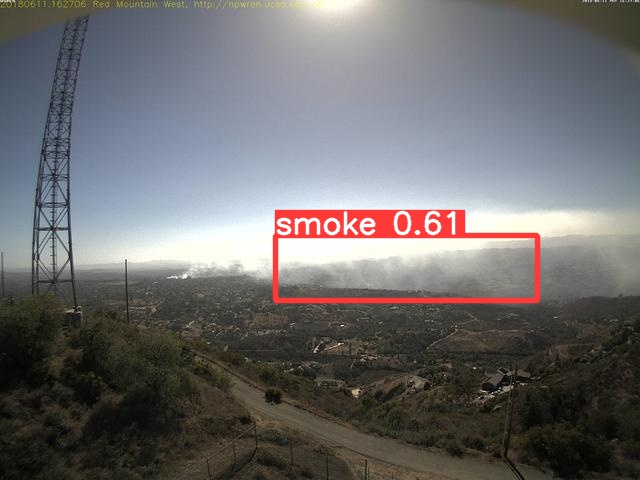

You see Predictive Probability in the BoX 



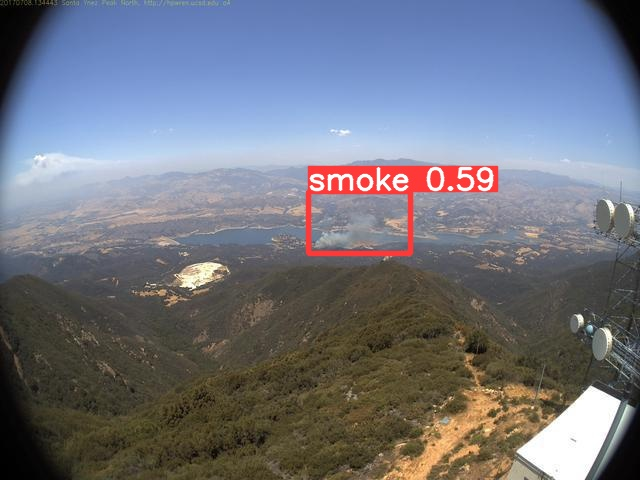

You see Predictive Probability in the BoX 



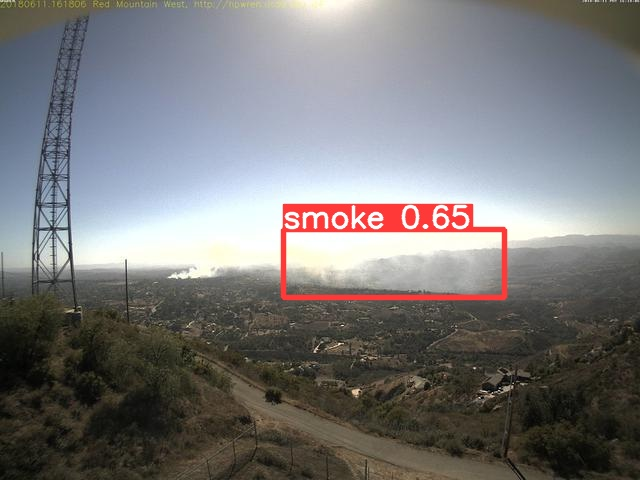

You see Predictive Probability in the BoX 



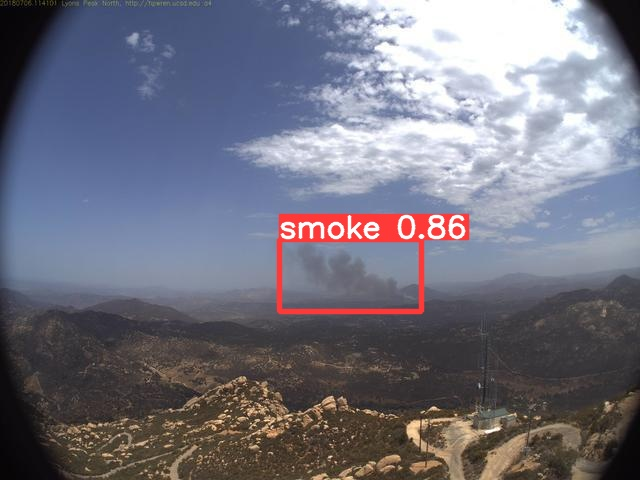

You see Predictive Probability in the BoX 



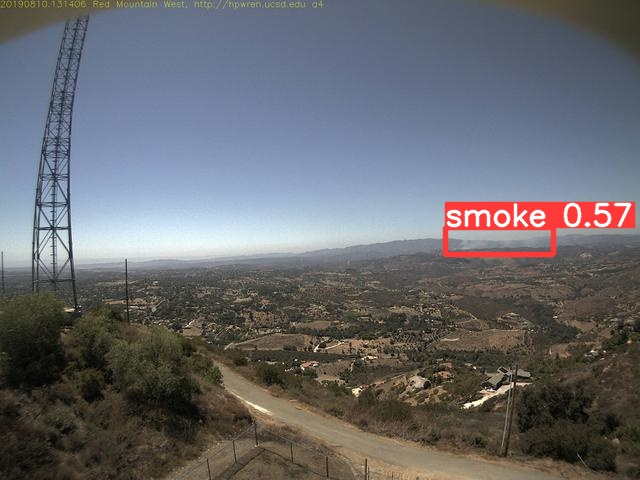

You see Predictive Probability in the BoX 



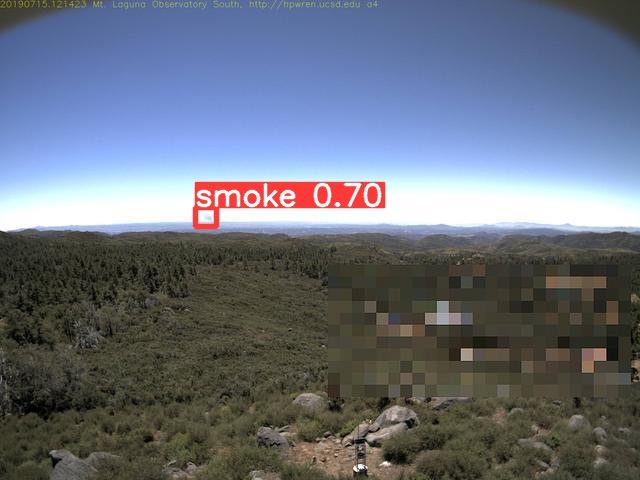

You see Predictive Probability in the BoX 



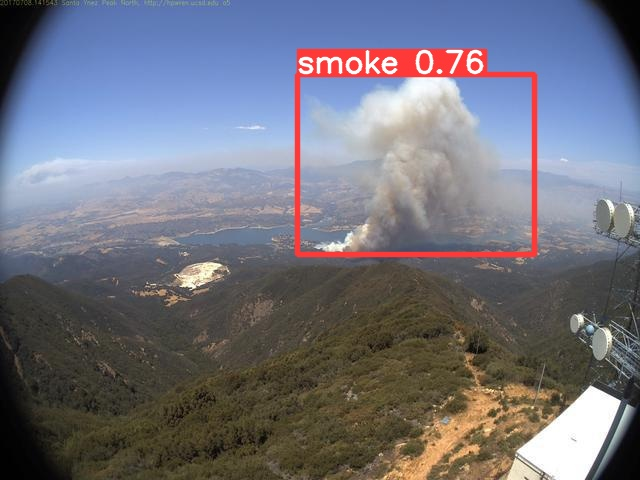

You see Predictive Probability in the BoX 



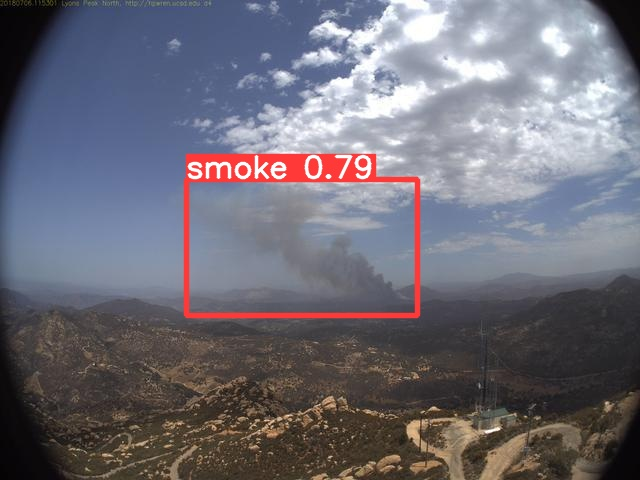

You see Predictive Probability in the BoX 



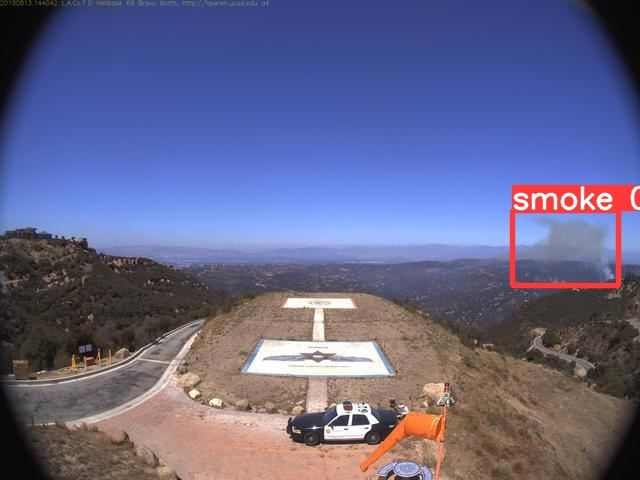

You see Predictive Probability in the BoX 



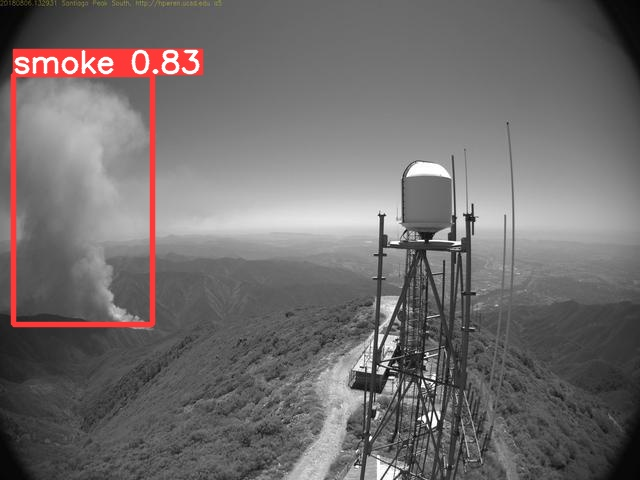

You see Predictive Probability in the BoX 



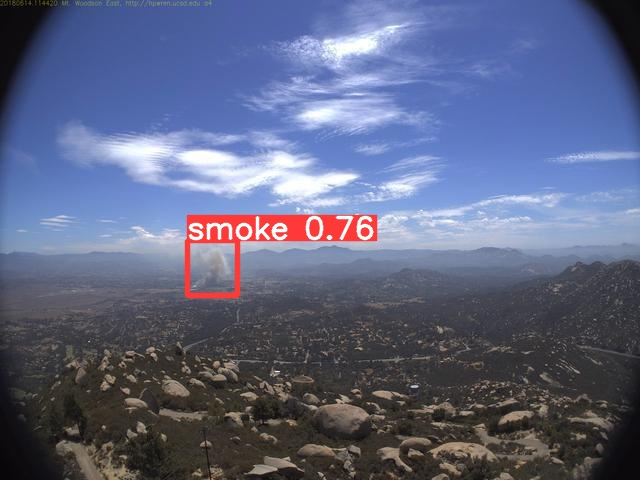

You see Predictive Probability in the BoX 



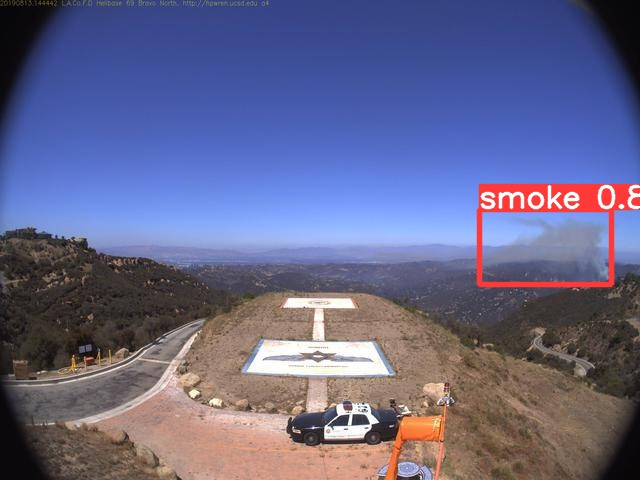

You see Predictive Probability in the BoX 



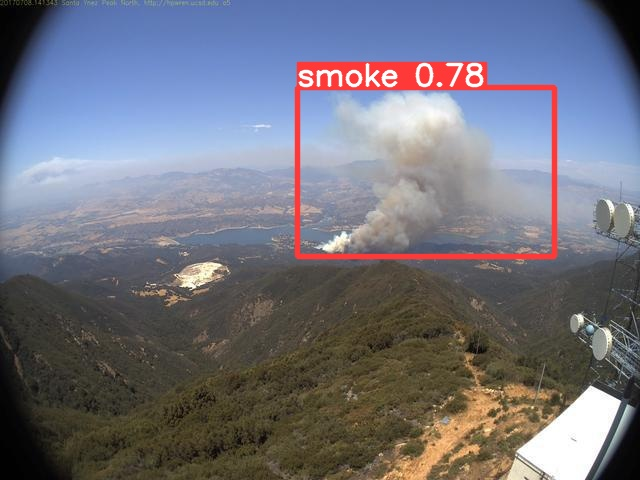

You see Predictive Probability in the BoX 



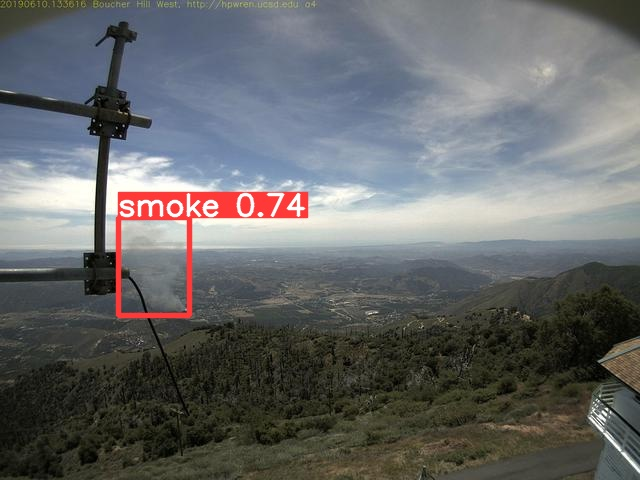

You see Predictive Probability in the BoX 



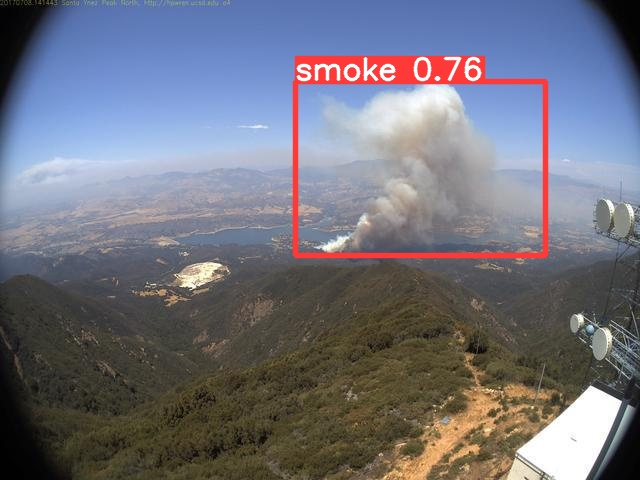

You see Predictive Probability in the BoX 



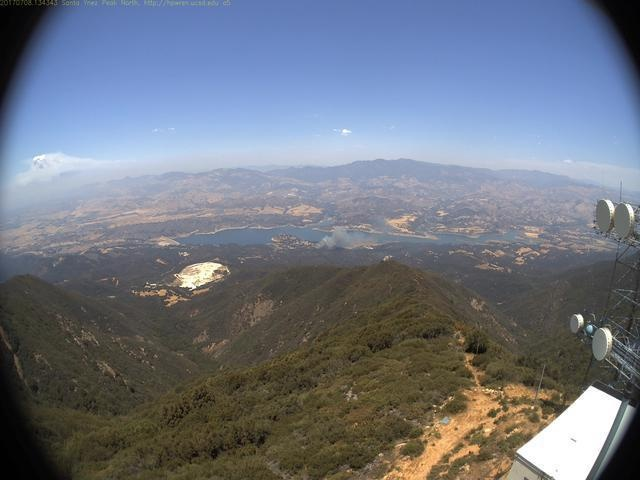

You see Predictive Probability in the BoX 



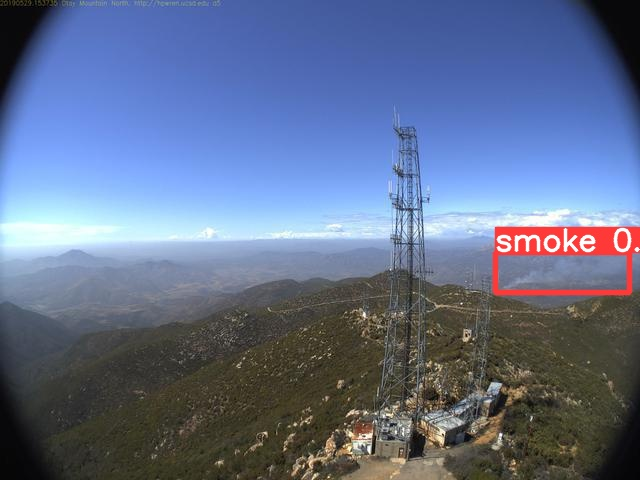

You see Predictive Probability in the BoX 



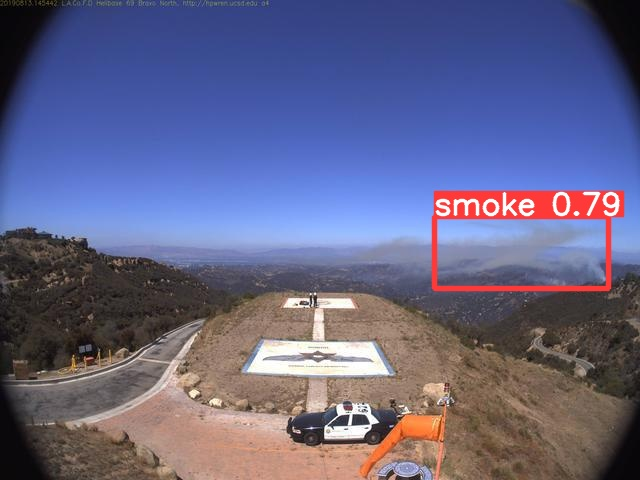

You see Predictive Probability in the BoX 



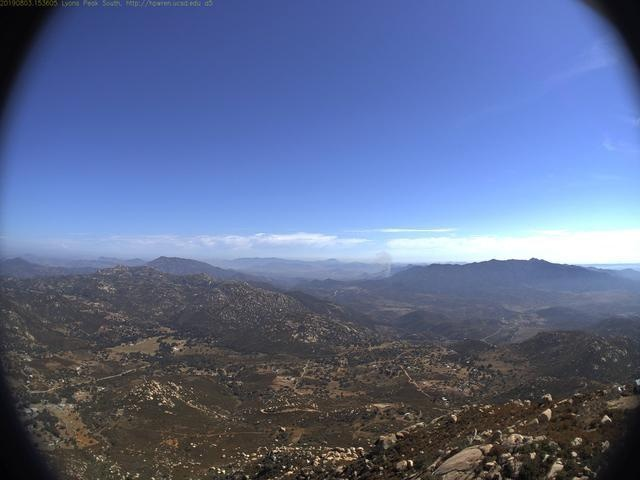

You see Predictive Probability in the BoX 



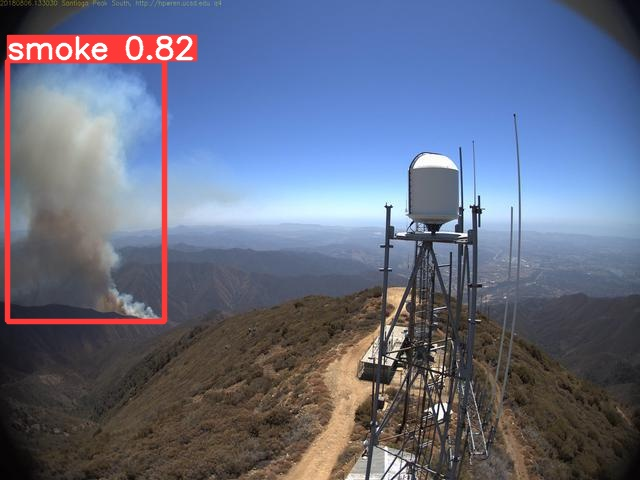

You see Predictive Probability in the BoX 



In [17]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg'):
    display(Image(filename=imageName))
    print("You see Predictive Probability in the BoX \n")